# To do:

 - Figure out how to signal injuries
 - Create model that generates minutes projections
 - Feature engineer a game count column, and optimize how many games you should be taken per dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta
from haversine import haversine

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")
now = str(datetime.now().date())
print(f"Today's date:", now)

Today's date: 2025-12-13


In [2]:
%run ./common_utils.ipynb

# Feature Engineering

In [3]:
import math

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def travel_km_from_row(row):
    prev = row['PrevLocation']
    cur  = row['Location']
    # missing prev => first game => no travel
    if pd.isna(prev) or pd.isna(cur):
        return 0.0
    # same arena => 0
    if prev == cur:
        return 0.0
    # lookup coords
    prev_coords = arenas.get(prev)
    cur_coords  = arenas.get(cur)
    if not prev_coords or not cur_coords:
        # fallback if code not found
        return 0.0
    return haversine_km(prev_coords[0], prev_coords[1], cur_coords[0], cur_coords[1])

In [4]:
def setup_df(df):
    df = df.sort_values(['Player', 'Date'])

    # Encode string cols
    team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
    df["Team"] = team_encoder.transform(df["Team"])
    df["Opp"] = team_encoder.transform(df["Opp"])
    df["Player"] = player_encoder.fit_transform(df["Player"])
    df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
    
    # Location based features
    df["PrevOpp"] = df.groupby("Player")["Opp"].shift(1)
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1).fillna(31)
    df['travel_km'] = df.apply(travel_km_from_row, axis=1).fillna(0)
    df['travel_hours'] = df['travel_km'] / 800.0      # approximate flight hours
    df['is_long_trip'] = (df['travel_km'] > 1500).astype(int)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)

    stat_cols = []
    for stat in categories:
        for col in [f'Off_{stat}', f'Off_L5_{stat}', f'Def_{stat}', f'Def_L5_{stat}']:
            stat_cols.append(col)

    final_cols = ['Date', 'Team', 'Team_type', 'B2B', 'cup_gm', 'pstszn_gm', 'Player', 'Opp', 
                  'DaysLstGm', 'travel_km', 'travel_hours', 'PrevLocation', 'is_long_trip', 'same_arena', 
                  tgt_stat] + stat_cols
    df = df[final_cols].fillna(0)

    return df

In [9]:
tgt_stat = "PTS"

df = pd.DataFrame()
df2 = pd.DataFrame()
for i in [2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_actuals.csv")
    df = pd.concat([df, df_actuals])

    df_gms = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_gms['Date'] = pd.to_datetime(df_gms.Date)
    df2 = pd.concat([df2, df_gms])

df['Date'] = pd.to_datetime(df.Date)

df['Tms'] = df['game_id'].apply(lambda x: x.split("_")[1:3])
df['WrngTm'] = df.apply(lambda row: 0 if row['Team'] in row['Tms'] else 1, axis=1)
df['WrngOpp'] = df.apply(lambda row: 0 if row['Opp'] in row['Tms'] else 1, axis=1)
df = df[(df.WrngTm == 0) & (df.WrngOpp == 0)]

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()

df2['Date'] = pd.to_datetime(df2.Date)
df_mtch = df2[['Date', 'AwayABV', 'HomeABV', 'AwayB2B', 'HomeB2B', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Home'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Date','Team', 'Opp', 'B2B', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Date','Team', 'Opp', 'B2B', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Away'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Date', 'Team', 'Team_type', 'cup_gm', 'pstszn_gm']]
df = df.merge(df_mtch, on=['Date', 'Team'])

df = setup_df(df)

display(df)

,Date,Team,Team_type,B2B,cup_gm,pstszn_gm,Player,Opp,DaysLstGm,travel_km,travel_hours,PrevLocation,is_long_trip,same_arena,PTS,Off_PTS,Off_L5_PTS,Def_PTS,Def_L5_PTS,Off_AST,Off_L5_AST,Def_AST,Def_L5_AST,Off_REB,Off_L5_REB,Def_REB,Def_L5_REB,Off_PR,Off_L5_PR,Def_PR,Def_L5_PR,Off_PA,Off_L5_PA,Def_PA,Def_L5_PA,Off_RA,Off_L5_RA,Def_RA,Def_L5_RA,Off_PRA,Off_L5_PRA,Def_PRA,Def_L5_PRA,Off_TPM,Off_L5_TPM,Def_TPM,Def_L5_TPM,Off_STL,Off_L5_STL,Def_STL,Def_L5_STL,Off_BLK,Off_L5_BLK,Def_BLK,Def_L5_BLK,Off_STL_BLK,Off_L5_STL_BLK,Def_STL_BLK,Def_L5_STL_BLK
393,2023-10-26,16,0,0,0,0,0,22,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,5.000000,5.0,0.000000,0.000000,3.000000,3.0,0.000000,0.000000,4.000000,4.0,0.000000,0.000000,9.000000,9.0,0.000000,0.0,8.000000,8.0,0.000000,0.00,7.000000,7.0,0.000000,0.000000,12.000000,12.0,0.000000,0.000000,1.000000,1.0,0.000000,0.0,2.000000,2.0,0.00,0.00,0.000000,0.0,0.000,0.0,2.000000,2.0
981,2023-10-29,16,0,0,0,0,0,0,3,0.0,0.0,22.0,0,0,7,3.500000,3.500000,16.833333,15.4,0.000000,0.000000,3.500000,3.0,0.500000,0.500000,3.500000,3.2,4.000000,4.000000,20.333333,18.6,3.500000,3.5,20.333333,18.4,0.500000,0.50,7.000000,6.2,4.000000,4.000000,23.833333,21.6,1.000000,1.000000,2.500000,2.6,0.000000,0.0,0.833333,1.0,0.00,0.00,0.166667,0.2,0.000,0.0,1.000000,1.2
1216,2023-10-30,16,0,0,0,0,0,15,1,0.0,0.0,0.0,0,0,0,2.333333,2.333333,12.800000,12.8,0.666667,0.666667,3.000000,3.0,0.333333,0.333333,3.800000,3.8,2.666667,2.666667,16.600000,16.6,3.000000,3.0,15.800000,15.8,1.000000,1.00,6.800000,6.8,3.333333,3.333333,19.600000,19.6,0.666667,0.666667,2.400000,2.4,0.000000,0.0,0.800000,0.8,0.00,0.00,1.200000,1.2,0.000,0.0,2.000000,2.0
1613,2023-11-01,16,1,0,0,0,0,27,2,0.0,0.0,15.0,0,0,2,2.250000,2.250000,11.125000,11.4,0.750000,0.750000,2.125000,2.0,0.500000,0.500000,6.375000,6.0,2.750000,2.750000,17.500000,17.4,3.000000,3.0,13.250000,13.4,1.250000,1.25,8.500000,8.0,3.500000,3.500000,19.625000,19.4,0.500000,0.500000,1.875000,2.0,0.000000,0.0,1.125000,1.2,0.00,0.00,0.625000,1.0,0.000,0.0,1.750000,2.2
2132,2023-11-03,16,0,0,1,0,0,19,2,0.0,0.0,27.0,0,0,0,1.800000,1.800000,17.285714,18.2,0.600000,0.600000,3.714286,3.6,0.400000,0.400000,4.571429,3.8,2.200000,2.200000,21.857143,22.0,2.400000,2.4,21.000000,21.8,1.000000,1.00,8.285714,7.4,2.800000,2.800000,25.571429,25.6,0.400000,0.400000,2.000000,2.6,0.000000,0.0,1.285714,1.2,0.00,0.00,0.428571,0.2,0.000,0.0,1.714286,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66973,2025-11-29,18,1,0,0,0,714,9,5,0.0,0.0,3.0,0,0,25,21.777778,20.400000,16.562500,12.8,4.000000,3.800000,2.437500,2.0,6.125000,4.800000,5.625000,5.0,27.222222,25.200000,22.187500,17.8,25.777778,24.2,19.000000,14.8,9.444444,8.60,8.062500,7.0,31.222222,29.000000,24.625000,19.8,0.000000,0.000000,0.000000,0.0,2.285714,1.6,0.875000,0.6,1.25,1.25,0.312500,0.4,2.625,2.2,1.187500,1.0
51134,2025-01-30,14,0,0,0,0,715,10,0,0.0,0.0,31.0,0,0,0,0.000000,0.000000,13.171717,20.4,0.000000,0.000000,2.979798,4.8,0.000000,0.000000,3.818182,6.0,0.000000,0.000000,16.989899,26.4,0.000000,0.0,16.151515,25.2,0.000000,0.00,6.797980,10.8,0.000000,0.000000,19.969697,31.2,0.000000,0.000000,1.818182,1.8,0.000000,0.0,1.010101,1.8,0.00,0.00,0.373737,0.6,0.000,0.0,1.383838,2.4
51852,2025-02-03,14,0,0,0,0,715,26,4,0.0,0.0,10.0,0,0,0,0.000000,0.000000,13.696078,8.8,0.000000,0.000000,3.225490,2.6,0.000000,0.000000,3.833333,3.2,0.000000,0.000000,17.529412,12.0,0.000000,0.0,16.921569,11.4,0.000000,0.00,7.058824,5.8,0.000000,0.000000,20.754902,14.6,0.000000,0.000000,1.970588,0.6,0.000000,0.0,1.147059,0.4,0.00,0.00,0.254902,0.0,0.000,0.0,1.401961,0.4
52878,2025-02-08,14,0,1,0,0,715,20,5,0.0,0.0,26.0,0,0,0,0.000000,0.000000,12.155963,15.2,0.000000,0.000000,2.697248,2.2,0.000000,0.000000,3.954128,5.6,0.000000,0.000000,16.110092,20.8,0.000000,0.0,14.853211,17.4,0.000000,0.00,6.6

# Baseline Model

In [10]:
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))

feature_cols = [col for col in df.columns 
                if col not in ['Date', tgt_stat]]

X_train, y_train = train_df[feature_cols], train_df[tgt_stat]
X_val,   y_val   = val_df[feature_cols],   val_df[tgt_stat]
X_test,  y_test  = test_df[feature_cols],  test_df[tgt_stat]


model = XGBRegressor(
    enable_categorical=True,
    n_estimators=300,    # number of trees
    learning_rate=0.05,  # step size
    max_depth=6,         # complexity
    subsample=0.8,       # row sampling
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Train: 47618 / Validation: 10204 / Test: 10205
RMSE: 4.711944927845799
MAE: 3.3265602588653564
R²: 0.7497280240058899


,feature,importance,pct
0,Off_L5_PTS,20170.779297,0.510831
1,Off_L5_PA,7642.378418,0.704376
2,Off_L5_PR,1043.614258,0.730806
3,Def_L5_PTS,860.851929,0.752607
4,Off_PTS,378.395020,0.762190
5,Def_L5_PR,370.026611,0.771561
6,Def_L5_TPM,290.327148,0.778914
7,Def_L5_PA,287.219116,0.786188
8,Def_L5_RA,258.682800,0.792739
9,Def_L5_PRA,252.337753,0.799130


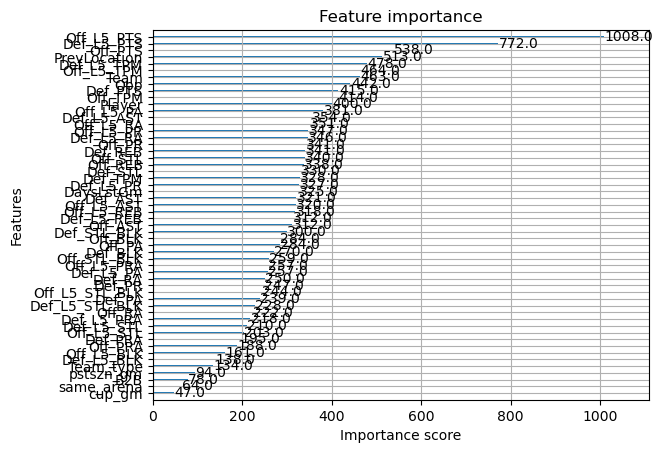

In [11]:
importance = model.get_booster().get_score(importance_type='gain')

# Convert to table
df_importance = (
    pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    })
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
)

df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
display(df_importance[(df_importance.pct <= .85)])

xgb.plot_importance(model)
plt.show()

# Hyperparameter tuning

In [ ]:
param_dist = {
    "n_estimators": randint(300, 2000),
    "learning_rate": uniform(0.005, 0.05),
    "max_depth": randint(3, 8),
    "min_child_weight": randint(1, 15),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 10),
    "reg_lambda": uniform(0, 10),
    "reg_alpha": uniform(0, 5),
    "max_leaves": randint(10, 80)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_, "\n")

preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
pred_col = f'{tgt_stat}_Pred'
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[['Date', 'Team', 'Player', f'{tgt_stat}_line']]
test_df[pred_col] = preds
test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])

df_test = test_df.merge(df_lines, on=['Date', 'Team', 'Player'])
df_test = df_test[[c for c in df_test.columns if c != pred_col] + [pred_col]]

df_test['Diff'] = df_test[f'{tgt_stat}_Pred'] - df_test[f'{tgt_stat}_line']
df_test['Act_Res'] = np.where(df_test[tgt_stat] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['Pred_Res'] = np.where(df_test[pred_col] > df_test[f'{tgt_stat}_line'], 'O', 'U')
df_test['ParlayHit'] = np.where(df_test['Act_Res'] == df_test['Pred_Res'], 1, 0)

df_test['Diff2'] = abs(df_test[f'{tgt_stat}_Pred'] - df_test[tgt_stat])
df_test['InRMSE_Range'] = np.where(df_test['Diff2'] <= rmse, 1, 0)

print("Total Accuracy (ParlayHit):", ((df_test.ParlayHit == 1).sum() / df_test.shape[0]))
print((df_test.ParlayHit == 1).sum(), "/", df_test.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_test.InRMSE_Range == 1).sum() / df_test.shape[0]))
print((df_test.InRMSE_Range == 1).sum(), "/", df_test.shape[0])

In [ ]:
df_ystrday = df_test[(df_test.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
            [['Team', 'Player', tgt_stat, f'{tgt_stat}_line', f'{tgt_stat}_Pred', 'ParlayHit', 'Diff', 'InRMSE_Range', 'Diff2']]\
            .sort_values(f'{tgt_stat}_line', ascending=False)

print("Yesterday's Results:")
if df_ystrday.shape[0] >= 50:
    for tm in df_ystrday.Team.unique():
        display(df_ystrday[df_ystrday.Team == tm])
else:
    display(df_ystrday)

# Today's predictions

In [ ]:
df_pred = pd.read_csv("../tables/2025/parlay_stats.csv")
df_pred['Date'] = pd.to_datetime(df_pred.Date)
for col in df_pred.select_dtypes(include='object').columns:
    df_pred[col] = df_pred[col].astype('category')
df_pred = df_pred.merge(df_mtch, on=['Date', 'Team'])
df_pred[tgt_stat] = 0
df_pred = setup_df(df_pred)
# Filter → then select feature columns
df_pred = df_pred[df_pred.Date == now][feature_cols]

# Predict
df_pred[f"{tgt_stat}_proj"] = best_model.predict(df_pred)
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

for tm in df_pred.Team.unique():
    display(df_pred[(df_pred.Team == tm) & ~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', f'{tgt_stat}_line', f'{tgt_stat}_proj']]\
            .sort_values(f'{tgt_stat}_proj', ascending=False))